# Whats here!

**DNA is usually represented as a text sequence, leveraging 4 letters to represent the constituent parts** - A (Adenosine), C (Cytosine), G (Guanine) and T (Thymine).

In this notebook I analye the genomic sequence of the bacterium **Caulobacter Crescentus**

bsed on our work we could analyze DNA damages https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3127433/ chromosomal replication https://www.sciencedirect.com/science/article/abs/pii/S0147619X11001156
and other fancy stuff.


# Basics

## Import relevant Packages

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import itertools
import umap as ump

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 
from sklearn.preprocessing import StandardScaler

/home/theia/anaconda3/envs/genomix/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/theia/anaconda3/envs/genomix/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/theia/anaconda3/envs/genomix/lib/python3.9/site-packages/umap/dist

## Read Data

In [2]:
# not a genereic CSV so we read as file
with open ("ccrescentus.fa", "r") as inputFile:
    data = inputFile.readlines()

# concat line
gCode = ''
for line in data[1:]:
    gCode += line.strip()
    
# count genome(a,g,t,c) precense
aCount = gCode.count('a')
gCount = gCode.count('g')
tCount = gCode.count('t')
cCount = gCode.count('c')


In [3]:

# check data
# first 30 chars
print(gCode[0:30])
# are there non genome chars?
print('Test: only real genomes (acgt) ?')
# chech that subsets in sum match data in length
print(aCount + gCount + tCount + cCount == len(gCode))


gccgatagcctatgatccccggcaggcccg
Test: only real genomes (acgt) ?
True


In [4]:
# size of the sub strings (data points)
size = 300

dataPoints = []

# copy code into string to remove first element iteratively
tempString = gCode

# iteratively remove left chunk & add to array
while len(tempString) > 0:
    dataPoints.append(tempString[0:size])
    tempString = tempString[size:]


In [5]:
len(dataPoints)

1017

In [48]:
print(len(dataPoints[0]))
print(len(dataPoints[1016]))

300
300


In [6]:
print(dataPoints[0])

gccgatagcctatgatccccggcaggcccggggcttggagccgtctggtttggatggaaccctccaaaccagatcaagaggctcctagaacgccgcccgcagggtcacgccccaggtgcgcgggtcgcccggctggccggcgatcaggccggtgttgctgggacccacggccagttgctcgaaatagttctcgtcgaaggcgttgcggacccaggcatagaggttcagcccctcaggcgtgcggaagccggcccggaagttagcgatcgtgtagccgtcaacccaggtgtagatcgaggg


In [7]:
print(dataPoints[1])

cgaagggttggacgagaacttgctgcggtagctgccgtcatagccgacatagaactcgcccgtcttgcccaggaagtcgcccggaacattggcctcggcccccagggccacgctccacttcgaaacgcccggcagccgctgacccgagacgtcgcagttggcggggctgagcgcgccggccacgccggccgcgcgcggaacctgggttccggtcgccaccgtgccgcccgacagttccggcgggcagggcgcgtcgacaaagcgcacatacttggcgtcggtataggcggcgttcagata



so we have 1017 datapoints each with a length of 300 with a seemingly random frequence of the 4 nucleobases.
lets analyze!


# Explorative Data Analysis

## Frequency Tables

In [8]:
iterables = ['a','g','t','c']
wordsDict =  {}

# for words of size 1 to 4, calc the cartesian product
# so we get  all "possibilities"
for i in range(1,5):
    words = []
    iterator = itertools.product(iterables, repeat = i)
    for word in iterator:
        s = ''
        for t in word:
            s += t
        words.append(s)
    wordsDict[i] = words

# print the dict for 3 let words
print(wordsDict[3])

['aaa', 'aag', 'aat', 'aac', 'aga', 'agg', 'agt', 'agc', 'ata', 'atg', 'att', 'atc', 'aca', 'acg', 'act', 'acc', 'gaa', 'gag', 'gat', 'gac', 'gga', 'ggg', 'ggt', 'ggc', 'gta', 'gtg', 'gtt', 'gtc', 'gca', 'gcg', 'gct', 'gcc', 'taa', 'tag', 'tat', 'tac', 'tga', 'tgg', 'tgt', 'tgc', 'tta', 'ttg', 'ttt', 'ttc', 'tca', 'tcg', 'tct', 'tcc', 'caa', 'cag', 'cat', 'cac', 'cga', 'cgg', 'cgt', 'cgc', 'cta', 'ctg', 'ctt', 'ctc', 'cca', 'ccg', 'cct', 'ccc']


In [9]:
# dictionary that will contain the frequency table for each word size
freqTables = {}

for i in range(1,5):
    # create an empty dataFrame with columns being the words on the dictionary
    df = pd.DataFrame(columns = wordsDict[i])
    for index, dataP in enumerate(dataPoints):
        # we create a row with zero values corresponding to a data point
        df.loc[index] = np.zeros(len(wordsDict[i]))
        while len(dataP) > 0:
            # get the left part of the data point (i characters)
            left = dataP[0:i]
            # find it in the respective column and count it there
            df.loc[index, left] += 1
            dataP = dataP[i:]
    freqTables[i] = df


In [10]:
freqTables[3].head()

,aaa,aag,aat,aac,aga,agg,agt,agc,ata,atg,...,cgt,cgc,cta,ctg,ctt,ctc,cca,ccg,cct,ccc
0,0.0,1.0,0.0,3.0,0.0,2.0,0.0,2.0,2.0,0.0,...,2.0,2.0,2.0,1.0,1.0,4.0,4.0,4.0,1.0,1.0
1,1.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0,5.0,0.0,...,2.0,4.0,0.0,2.0,4.0,2.0,1.0,1.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,2.0,4.0,0.0,4.0,5.0,4.0,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,4.0,0.0,5.0,5.0,2.0,2.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,1.0,...,2.0,2.0,0.0,8.0,3.0,1.0,5.0,1.0,0.0,0.0


## lets PCA or better UMAP


hence both PCA and K-meansare distance-based algorithms, we have to normalize / standardize the data:
1. we first run sklearn to **standardize** the data by columns.resulting in  the **same averages** and dispersions across the data.
2. then we use UMAP to reduce dimensions ;)

In [11]:

normFreqTables = {}
sc = StandardScaler(copy=True, with_mean=True, with_std=True)

for i in range(1,5):
    data = freqTables[i]
    data = sc.fit_transform(data)
    normFreqTables[i] = pd.DataFrame(data, columns = wordsDict[i])


In [12]:
# sanity check
print(normFreqTables[2].loc[:, 'gt'].mean())
print(normFreqTables[2].loc[:, 'gt'].std())

-9.781315929834221e-17
1.0004920049498147


In [13]:
reducer = ump.UMAP(n_components=3)

#empty dict, so for each word size, we can store the 2D embeddings in a seperate table 
pCompTables = {}

for i in range(1,5):
    reducer.fit(normFreqTables[i])
    embedding = reducer.transform(normFreqTables[i])
    # add a table with the 2D embeddings to the dict
    pCompTables[i] = pd.DataFrame(embedding[:, [0,1]], columns = ['pc1', 'pc2'])
    


        pc1        pc2
0  5.720585  10.246841
1  5.962716   8.363182
2  7.748477   9.474578
3  7.612299   8.508735
4  7.783941   9.300547


In [ ]:
# sanity check
# print(pCompTables[2].head())

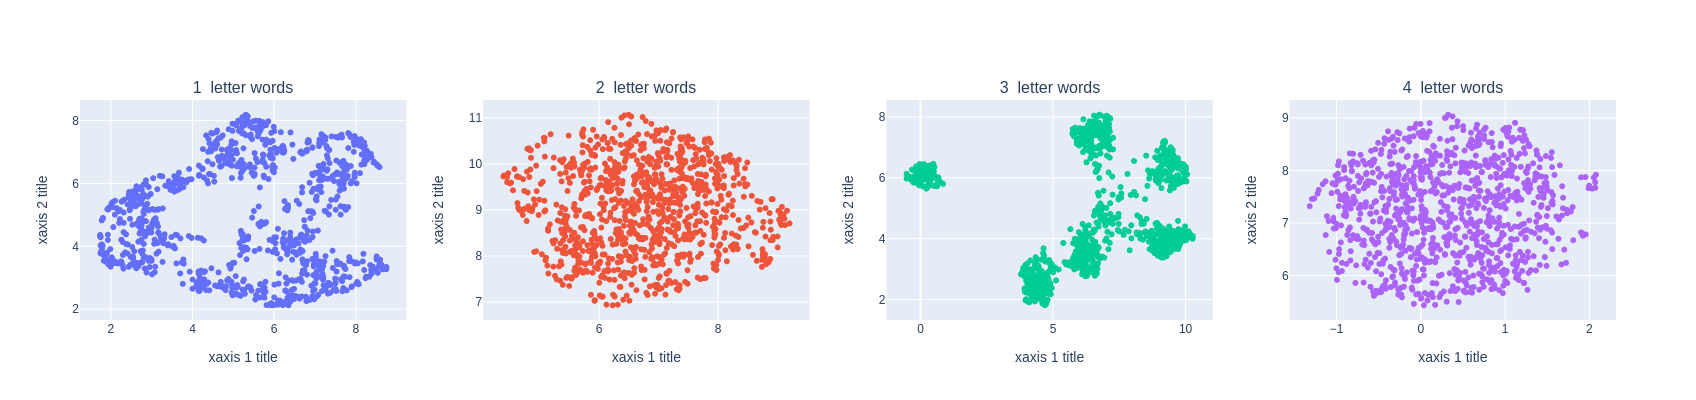

In [41]:
# plot results
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=1, 
                    cols=4, 
                    subplot_titles=("1  letter words", "2  letter words", "3  letter words", "4  letter words"))

# colors = {'a':'tab:blue', 'c':'tab:purple', 'g':'tab:green', 't':'tab:red'}

for i in range(1,5):
    #plt.subplot(2,2,i)
    x = pCompTables[i].loc[:,'pc1']
    y = pCompTables[i].loc[:,'pc2']
    fig.add_trace(
        go.Scatter(x=x, y=y, mode="markers"),
        row=1, col=i
    )
    title = str(i) + ' letter words'
    fig.update_traces(name=title, showlegend = False)
    fig.update_xaxes(title_text="xaxis 1 title", row=1, col=i)
    fig.update_yaxes(title_text="xaxis 2 title", row=1, col=i)

fig.update_layout(height=400, width=1200)
fig.show()

## Clustering

Now we can use clustering algorithms to determine subpattern

In [55]:
# kmeans clustering for 3 letter words & 7 clusters
kmeans = KMeans(n_clusters =7, n_init=10)
kmeans.fit(normFreqTables[3])

KMeans(n_clusters=7, n_init=10)

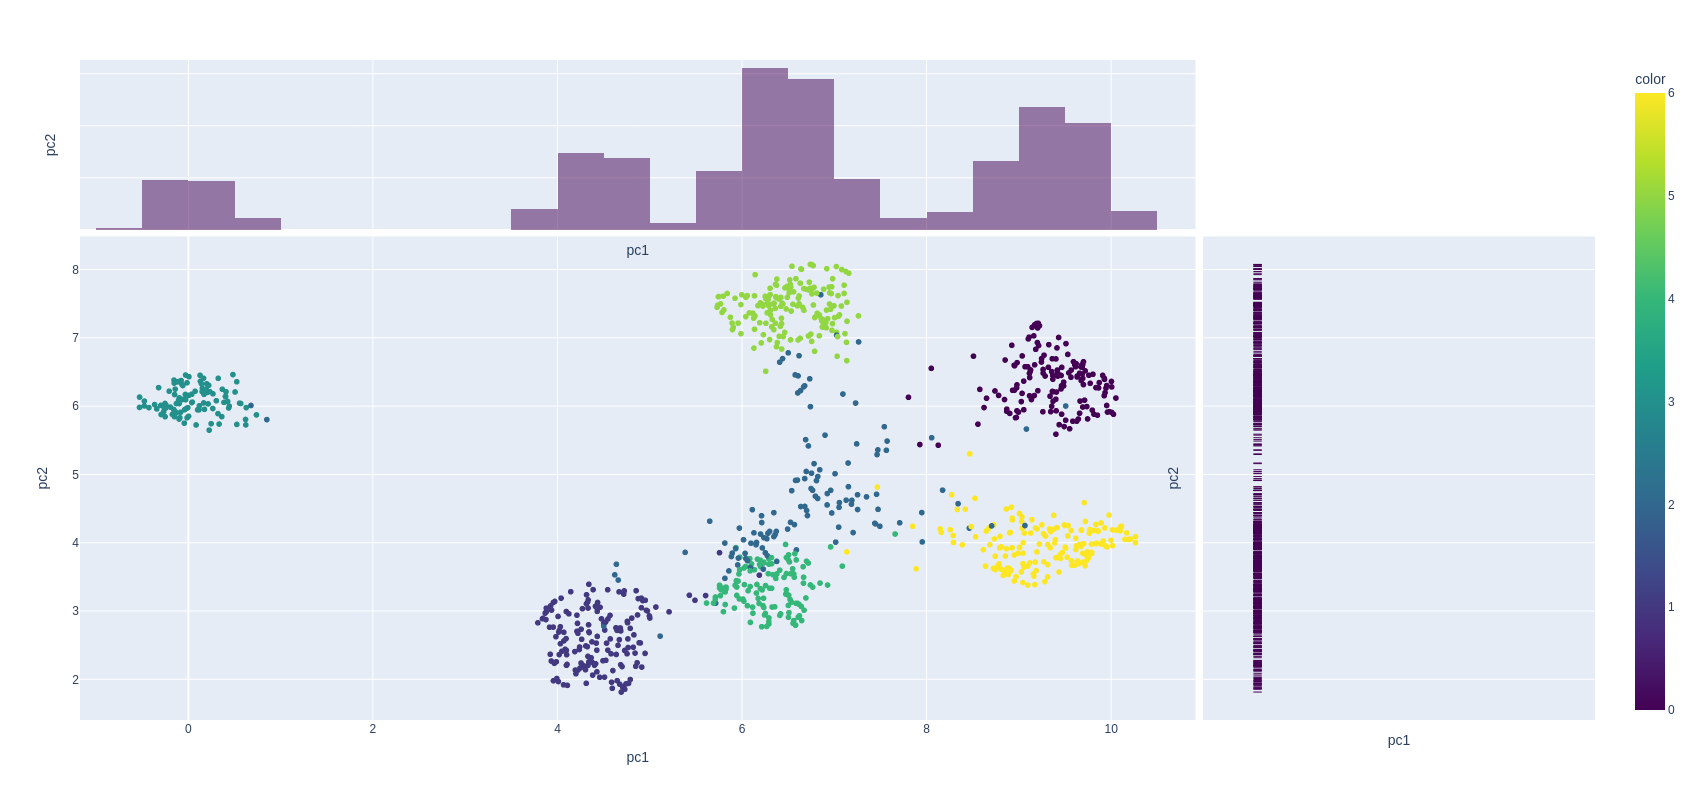

In [56]:
import plotly.express as px

x = pCompTables[3].loc[:,'pc1']
y = pCompTables[3].loc[:,'pc2']

fig = px.scatter(x=x, y=y, 
                 color=kmeans.labels_, 
                 marginal_x="histogram", 
                 marginal_y="rug", 
                 width=800, height=800, 
                 color_continuous_scale=px.colors.sequential.Viridis)

fig.update_xaxes(title_text="pc1")
fig.update_yaxes(title_text="pc2")

fig.show()

# Results

1. Our method enables us to **demonstrate, visualize and deliver evidence** how the DNA genetic sequence is structured into three-letter words (known as codons)
2. which in fact are the proteins (and amino acids) that living cells need to function.